In [1]:
import numpy as np
import pandas as pd
import multiprocessing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from skopt import gp_minimize
from skopt.learning import RandomForestRegressor
from skopt.space import Real, Categorical, Space
from skopt.utils import use_named_args
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.neighbors import NearestNeighbors
from scipy.special import jv

import json
class NumpyEncoder(json.JSONEncoder):
    """自定义JSON编码器，用于处理numpy数据类型"""
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        else:
            return super(NumpyEncoder, self).default(obj)
 

In [2]:
def estimate_ess(Y, W, X, alpha, support_indices):
        weights = np.zeros(X.shape[0])
        weights[support_indices] = np.abs(alpha)
        alpha = weights / np.sum(weights)
        
        treated_ess = (np.sum(alpha[W == 1]))**2 / np.sum(alpha[W == 1]**2)
        control_ess = (np.sum(alpha[W == -1]))**2 / np.sum(alpha[W == -1]**2)

        return treated_ess + control_ess
    
def estimate_diff(Y, W, X, alpha, support_indices):

    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    alpha = weights / np.sum(weights)
    
    treated_mean = np.mean(Y[W == 1])
    control_mean = np.mean(Y[W == -1])
    
    treated_std = np.std(Y[W == 1], ddof=1)
    control_std = np.std(Y[W == -1], ddof=1)

    normed_diff = np.abs(treated_mean - control_mean) / np.sqrt((treated_std**2 + control_std**2) / 2)

    return normed_diff

def estimate_ate(Y, W, X, alpha, support_indices):
    
    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    alpha = weights / np.sum(weights)
    
    treated_mean = np.sum(Y[W == 1] * alpha[W == 1]) / np.sum(alpha[W == 1])
    control_mean = np.sum(Y[W == -1] * alpha[W == -1]) / np.sum(alpha[W == -1])
    return treated_mean - control_mean



def compute_wnayman(Y_obs, W, X, alpha, support_indices):
    
    # 计算权重
    weights = np.zeros(X.shape[0])
    weights[support_indices] = np.abs(alpha)
    lambda_i = weights / np.sum(weights)
    
    # 计算mu_c(x)和mu_t(x)，这里需要根据具体数据进行定义
    mu_c = np.mean(Y_obs[W == -1])
    mu_t = np.mean(Y_obs[W == 1])

    # 计算sigma_c^2(x)和sigma_t^2(x)，这里需要根据具体数据进行定义
    sigma_c_squared = np.var(Y_obs[W == -1])
    sigma_t_squared = np.var(Y_obs[W == 1])

    # 计算mu_i和sigma_i^2
    mu_i = np.where(W == -1, mu_c, mu_t)
    sigma_i_squared = np.where(W == -1, sigma_c_squared, sigma_t_squared)

    N_t = np.sum(W == 1)
    N_c = np.sum(W == -1)

    # 计算条件抽样方差
    conditional_variance = np.sum(lambda_i[W == 1]**2 * sigma_i_squared[W == 1]) + np.sum(lambda_i[W == -1]**2 * sigma_i_squared[W == -1])
    
    stderr = np.sqrt(conditional_variance)


    print("条件抽样方差:", conditional_variance)
    return stderr


In [3]:
class ConvergenceStopper:
    def __init__(self, patience=10, tol=1e-6):
        self.patience = patience
        self.tol = tol
        self.best_value = np.inf
        self.no_improvement = 0
    
    def __call__(self, result):
        if len(result.x_iters) < 10:  # 至少10个点才开始检查
            return False
        
        current_min = np.min(result.func_vals)
        
        if self.best_value - current_min > self.tol:
            self.best_value = current_min
            self.no_improvement = 0
        else:
            self.no_improvement += 1
            
        return self.no_improvement >= self.patience

class BOStopper:
    def __init__(self, conv_patience=10, conv_tol=1e-6,
                 ci_width=0.2, ci_patience=10, max_iter=100):
        self.conv_stopper = ConvergenceStopper(conv_patience, conv_tol)
        # self.ci_stopper = ConfidenceIntervalStopper(ci_width, ci_patience)
        self.max_iter = max_iter
    
    def __call__(self, result):
        # 最大迭代次数检查
        if len(result.x_iters) >= self.max_iter:
            return True
            
        # 收敛检查
        if self.conv_stopper(result):
            return True
        
        # 置信区间检查
        # if self.ci_stopper(result):
        #     return True
            
        return False

In [4]:
def compute_class_weights(y):
    classes, counts = np.unique(y, return_counts=True)
    total = len(y)
    class_weights = {cls: total / (len(classes) * cnt) for cls, cnt in zip(classes, counts)}
    return np.array([class_weights[yi] for yi in y])


# ========== Step 3: 模糊权重 s_i ==========
def compute_fuzzy_membership(X, y, sigma=0.1):
    s = np.zeros(len(X))
    for label in np.unique(y):
        idx = np.where(y == label)[0]
        X_class = X.iloc[idx]
        center = X_class.mean(axis=0)
        distances = np.linalg.norm(X_class - center, axis=1)
        t1, tl = distances.min(), distances.max()
        normalized = (distances - t1) / (tl - t1 + 1e-8)
        s[idx] = (1 - sigma) * (normalized ** 2) + sigma
    return s


def bayesian_opt(Y, X, W, kernel, c_upper): 
    # Define the hyperparameter space
    dim_C = Real(low=1e-4, high=c_upper, prior='log-uniform', name='C')
    # dim_class_weight_1 = Real(low=0.1, high=2.0, prior='uniform', name='class_weight_1')
    # dim_class_weight_neg1 = Real(low=0.1, high=2.0, prior='uniform', name='class_weight_neg1')
    # gamma = Real(low=1e-4, high=1e1, prior='log-uniform', name='gamma')

    dimensions = [dim_C]
    # Define the target score function
    @use_named_args(dimensions=dimensions)
    def objective_1(**params): 
        # class_weight = {1: params['class_weight_1'], -1: params['class_weight_neg1']}
        clf = SVC(C=params['C'], kernel=kernel)

        C_i = compute_class_weights(W_train)
        sigma = 0.1  # You can adjust this value as needed
        s_i = compute_fuzzy_membership(X_train, W_train, sigma)
        weights = C_i * s_i
        # weights = np.array([class_weight[y] for y in W_train]) * s_i
        
        # return score  # We negate because we want to maximize accuracy
    
        clf.fit(X_train, W_train, sample_weight=weights)
        score = clf.score(X_test, W_test)
        # ess = estimate_ess(Y, W, X, alpha, support_indices)
        return -score
    
    @use_named_args(dimensions=dimensions)
    def objective_2(**params):
        # class_weight = {1: params['class_weight_1'], -1: params['class_weight_neg1']}
        clf = SVC(C=params['C'], kernel=kernel)

        C_i = compute_class_weights(W_test)
        sigma = 0.1  # You can adjust this value as needed
        s_i = compute_fuzzy_membership(X_test, W_test, sigma)
        weights = C_i * s_i
        # weights = np.array([class_weight[y] for y in W_test]) * s_i
        
        # return score  # We negate because we want to maximize accuracy
    
        clf.fit(X_test, W_test, sample_weight=weights)
        score = clf.score(X_train, W_train)
        # ess = estimate_ess(Y, W, X, alpha, support_indices)
        return -score


    #print(result)
    # Extract optimized hyperparameters
    def crossfitting(result, Y, X, W):
        best_params = result.x
        best_score = result.fun  # Negate to get the actual score

        C_i = compute_class_weights(W)
        sigma = 0.1  # You can adjust this value as needed
        s_i = compute_fuzzy_membership(X, W, sigma)
        weights = C_i * s_i
        

        C = best_params[0]
        # gamma = best_params[1]
        # class_weight = {1: best_params[1], -1: best_params[2]}

        # weights = np.array([class_weight[y] for y in W_train]) * s_i

        best_model = SVC(C=C, kernel=kernel)
        best_model.fit(X, W, sample_weight=weights)
        support_indices = best_model.support_
        alpha = np.abs(best_model.dual_coef_[0])
        ATE = estimate_ate(Y, W, X, alpha, support_indices)
        DIM = estimate_diff(Y, W, X, alpha, support_indices)
        ESS = estimate_ess(Y, W, X, alpha, support_indices)
        STD = compute_wnayman(Y, W, X, alpha, support_indices)
        
        print("Best Hyperparameters:", best_params)
        print("Best Cross-Validation Score:", best_score)
        print("ATE:", ATE)
        print("STD:", STD)

        return(ATE, DIM, ESS, C, STD)


    # Initialize the Bayesian Optimization
    n_initial_points = 5
    n_calls = 50

    # 定义综合停止器
    stopper_1 = BOStopper(
        conv_patience=10,
        conv_tol=1e-6,
        # ci_width=0.2,
        # ci_patience=10,
        max_iter=100
    )
    stopper_2 = BOStopper(
        conv_patience=10,
        conv_tol=1e-6,
        # ci_width=0.2,
        # ci_patience=10,
        max_iter=100
    )

    # rf = RandomForestRegressor(n_estimators=100)

    Y_train, Y_test, X_train, X_test, W_train, W_test = train_test_split(Y, X, W, test_size=0.5, random_state=42, stratify=W)

    result_1 = gp_minimize(objective_1, dimensions, n_initial_points=n_initial_points, callback=[stopper_1], random_state=42, verbose=True)
    result_1 = crossfitting(result_1, Y_test, X_test, W_test)

    result_2 = gp_minimize(objective_2, dimensions, n_initial_points=n_initial_points, callback=[stopper_2], random_state=42, verbose=True)
    result_2 = crossfitting(result_2, Y_train, X_train, W_train)

    ATE = (result_1[0] + result_2[0])/2
    DIM = (result_1[1] + result_2[1])/2
    ESS = result_1[2] + result_2[2]
    C = (result_1[3] + result_2[3])/2
    STD = (result_1[4] + result_2[4])/2

    return(ATE, DIM, ESS, C, STD)

In [ ]:
# Define the dataset and hyperparameter space
num_datasets = 100
simulation_results_A = {n: [] for n in range(num_datasets)}


kernels = ['rbf']
# pi_range = np.linspace(0.0, 1.0, 11)

# pi_range = [0.0]
# results = {pi: [] for pi in pi_range}

c_uppers = [1e+4, 1e+5, 1e+6]

results = {c_upper: [] for c_upper in c_uppers}


for n in range(num_datasets):
    # simulate_data = pd.read_csv('../data_A_2000/data_scenario_G_n_2000_dataset_{}.csv'.format(n))
    simulate_data = pd.read_csv('../data_B/data_B3_2000/dataset_{}.csv'.format(n))

    X = simulate_data.drop(columns=['T', 'Y'])
    T = simulate_data['T']
    Y = simulate_data['Y']

    W = 2 * T - 1

    for kernel in kernels:
        for c_upper in c_uppers:
            result = bayesian_opt(Y, X, W, kernel, c_upper)

            results[c_upper].append(result)


        data = results

        data_str = json.dumps(data, cls=NumpyEncoder, indent=4)


        with open(f'simu_B3_100_2000_fuzzy1.json', 'w') as f:
            f.write(data_str)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.1233
Function value obtained: -0.4950
Current minimum: -0.4950
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1314
Function value obtained: -0.4950
Current minimum: -0.4950
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.1642
Function value obtained: -0.4950
Current minimum: -0.4950
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.1153
Function value obtained: -0.4950
Current minimum: -0.4950
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.2442
Function value obtained: -0.4950
Current minimum: -0.4950
Iteration No: 6 started. 

In [14]:
import json
import pandas as pd
import numpy as np

with open('../results/rbf/simu_B_100_2000_fuzzy.json', 'r') as f:
    data_str = f.read()

results = json.loads(data_str)
print(results)

c_upper = []
kernel_ate_estimates = []
for c_uppers, models in results.items():
    for model in models:
        c_upper.append(float(c_uppers))
        kernel_ate_estimates.append(float(model[0]))

data = pd.DataFrame({'c_upper': c_upper, 'ATE': kernel_ate_estimates})

# 分组
grouped_data = data.groupby('c_upper')['ATE'].apply(list).tolist()

# 计算每个分组的平均值和方差
grouped_stats = []
for group in grouped_data:
    mean = np.mean(group)
    variance = np.var(group, ddof=1)  # 使用样本方差
    grouped_stats.append({'mean': mean, 'variance': variance})

# 打印结果
for i, stats in enumerate(grouped_stats):
    print(f"c_upper: 1e+{i+3}, Mean: {stats['mean']}, Variance: {stats['variance']}")

{'1000.0': [[17.423479601332218, 0.575273191340573, 1534.1367145519628, 846.2449958077764, 0.9849625885974689], [15.704189376806667, 0.5581101940130434, 1368.2294485918342, 669.9792586994297, 1.0462002393590188], [15.614660155389515, 0.564879833501986, 1393.452301220379, 1000.0, 0.9824037111702095], [18.41171970218356, 0.6020115010862566, 1353.0306803954677, 1000.0, 1.042546179423093], [15.169544748202938, 0.6372731027931071, 1418.6183483497343, 518.8265573830838, 1.000140667473699], [16.536666832277888, 0.6325664168255862, 1366.2296448677444, 518.8265573830838, 1.040003085423157], [14.21630659290608, 0.6131898272283933, 1344.1585563263661, 285.7719003338639, 1.0491019584627326], [17.2524002404312, 0.5222544656979791, 1474.1607896934063, 999.192204232194, 1.0426590464074112], [14.601209117570633, 0.5202242311931224, 1414.0779707370243, 998.8853579565548, 1.0132895559459711], [11.375099093603922, 0.5995814199131599, 1362.7902387233557, 1000.0, 1.0923219295942843], [16.60937363641689, 0.

In [11]:
##PLOT ATE
def plot_ate(results):

    kernel = 'rbf'

    fig, axes = plt.subplots(1, 3,figsize=(12, 4))
    fig.subplots_adjust(hspace=0.4, wspace=0.3)

    i= 0

    # 过滤出当前kernel的所有模型
    i = i  
    c_upper = []
    kernel_ate_estimates = []
    for c_uppers, models in results.items():
        for model in models:
            c_upper.append(float(c_uppers))
            kernel_ate_estimates.append(float(model[0]))

    data = pd.DataFrame({'c_upper': c_upper, 'ATE': kernel_ate_estimates})
    grouped_data = data.groupby('c_upper')['ATE'].apply(list).tolist()
    #print(sorted(set(pi)))
    print(grouped_data)

    # x_sticks = pi
    x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    print(x_values)
    # 绘制箱型图
    axes[i].boxplot(grouped_data)
    # axes[i].axhline(y=-0.4, color='r', linestyle='--', label='True ATE (A)')
    axes[i].axhline(y=10, color='r', linestyle='--', label='True ATE (B)')
    #axes[i].set_xscale('log')
    axes[i].set_title(f'{kernel}')
    #axes[i].set_xticks(x_sticks)  # 保持刻度位置不变
    axes[i].set_xticklabels(x_values)
    axes[i].set_xlabel('c_upper')
    axes[i].set_ylabel('ATE')
    axes[i].legend()

    i += 1

    i = i  
    c_upper = []
    ESS = []
    for c_uppers, models in results.items():
        for model in models:
            c_upper.append(float(c_uppers))
            ESS.append(float(model[2]))

    data = pd.DataFrame({'c_upper': c_upper, 'ESS': ESS})
    grouped_data = data.groupby('c_upper')['ESS'].apply(list).tolist()
    #print(sorted(set(pi)))
    print(grouped_data)

    # x_sticks = pi
    x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    # 绘制箱型图
    axes[i].boxplot(grouped_data)
    axes[i].axhline(y=2000, color='r', linestyle='--', label='SS')
    #axes[i].set_xscale('log')
    axes[i].set_title(f'{kernel}')
    #axes[i].set_xticks(x_sticks)  # 保持刻度位置不变
    axes[i].set_xticklabels(x_values)
    axes[i].set_xlabel('c_upper')
    axes[i].set_ylabel('ESS')
    axes[i].legend()

    i += 1

    # i = i  
    # c_upper = []
    # DIM = []
    # for c_uppers, models in results.items():
    #     for model in models:
    #         c_upper.append(float(c_uppers))
    #         DIM.append(float(model[1]))
    

    # data = pd.DataFrame({'c_upper': c_upper, 'DIM': DIM})
    # grouped_data = data.groupby('c_upper')['DIM'].apply(list).tolist()
    # print(grouped_data)

    # x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    # # 绘制箱型图
    # axes[i].boxplot(grouped_data)
    # axes[i].set_title(f'{kernel}')
    # axes[i].set_xticklabels(x_values)
    # axes[i].set_xlabel('c_upper')
    # axes[i].set_ylabel('DIM')
    # axes[i].legend()

    i = i
    c_upper = []
    STD = []
    for c_uppers, models in results.items():
        for model in models:
            c_upper.append(float(c_uppers))
            STD.append(float(model[5]))
    
    data = pd.DataFrame({'c_upper': c_upper, 'STD': STD})
    grouped_data = data.groupby('c_upper')['STD'].apply(list).tolist()
    print(grouped_data)

    x_values = [f"$10^{{{int(np.log10(c))} }}$" for c in sorted(set(c_upper))]
    # 绘制箱型图
    axes[i].boxplot(grouped_data)
    axes[i].set_title(f'{kernel}')
    axes[i].set_xticklabels(x_values)
    axes[i].set_xlabel('c_upper')
    axes[i].set_ylabel('STD')
    axes[i].legend()


    plt.tight_layout()
    plt.show()

[[17.423479601332218, 15.704189376806667, 15.614660155389515, 18.41171970218356, 15.169544748202938, 16.536666832277888, 14.21630659290608, 17.2524002404312, 14.601209117570633, 11.375099093603922, 16.60937363641689, 6.570119025285763, 15.208309954299253, 19.487976559420247, 17.862516417857904, 19.95256732049782, 22.268690774610192, 15.408948363473769, 10.0999313403115, 14.185570649150634, 15.356448849452548, 12.997259905762235, 15.092471670588083, 19.47716952659958, 17.733197080074106, 18.746321199070977, 19.37727677635455, 19.224096599943962, 16.74234252921248, 10.756099147375494, 16.444715843783484, 19.772123473139743, 17.624903014069716, 15.933464291835179, 16.0795749129464, 16.983503881045053, 13.959369812970394, 16.586714482169896, 18.653921627190414, 9.869481043524047, 20.907330628420837, 19.84876738142637, 9.784187344115267, 9.687093907903005, 16.62959156294579, 18.021925972061723, 13.935830702559159, 14.563258429050762, 16.43537590776924, 18.32656057411681, 17.373413079797814,

IndexError: list index out of range

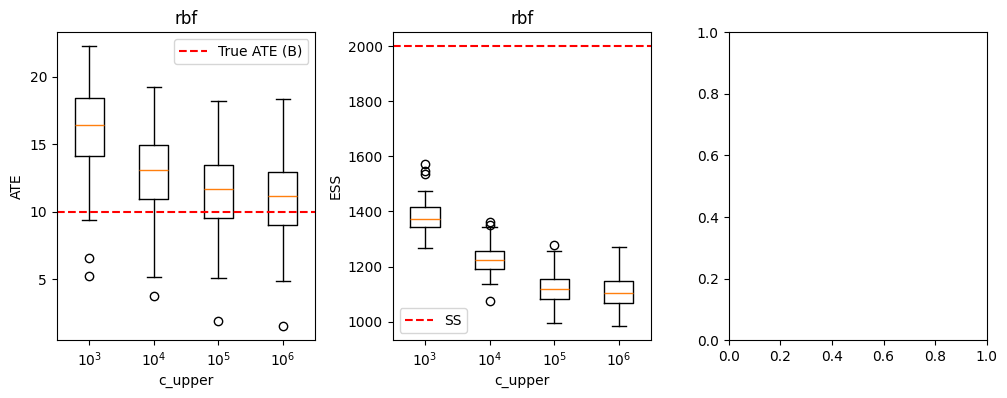

In [12]:
plot_ate(results)